In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#pip install wandb

Create a siamese network for immage classification

In [3]:
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm as tq
import matplotlib.pyplot as plt
from skimage.io import imshow
from pathlib import Path
import numpy as np
import random
import wandb

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
#from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau


In [4]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: thomas-borsani1. Use `wandb login --relogin` to force relogin


True

load data

In [5]:
#/content/drive/MyDrive/Colab Notebooks/efficent net/
npz = np.load('/content/drive/MyDrive/Colab Notebooks/efficent net/data/input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']

del npz

print('We have {} examples to work with'.format(Y_train.shape[0]))

We have 4113 examples to work with


plot some data

In [6]:
# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

def plot_image(ix):
    imshow(np.squeeze(X_train[ix,:,:,:]))#Looking at the combined channel
    plt.show()
    labels = ['Ship','Iceberg']  #0 is no iceberg(ship) and 1 is iceberg
    print ('This is:',labels[int(Y_train[ix])])


In [7]:
#plot_image(101)

In [8]:
#plot_image(100)

create a base network

In [106]:

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.apply(self._init_weights)
        self.conv = nn.Sequential(
            nn.Conv2d(3, 5, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(5, 5, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(5,7,3,padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        
        self.fc1=nn.Sequential(
            nn.Linear(2268,18),
            nn.Sigmoid())

        self.out = nn.Linear(18,1)
        

    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            module.weight.data.normal_(mean=0.0, std=0.01)
            if module.bias is not None:
                module.bias.data.normal_(mean=0.5, std=0.01)
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.2)
            if module.bias is not None:
                module.bias.data.normal_(mean=0.5, std=0.01)
        
    def forward_once(self,inp):
        inp=self.conv(inp)
        inp=self.fc1(inp)
        return inp

    def forward(self, inp1, inp2):
        out1=self.forward_once(inp1)
        out2=self.forward_once(inp2)
        dis=torch.abs(out2-out1)
        out=self.out(dis)
        return out

Create the pair of images to train on

In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, left_list, right_list,targets, transform):
        self.left_dat = left_list
        self.right_dat = right_list
        self.targets = targets
        self.transform = transform
        self.imag_nomr = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        left_img = self.left_dat[idx]
        right_img = self.right_dat[idx]
        targets = self.targets[idx]
        
        left_img = np.transpose(left_img,(2,0,1))
        left_img = torch.Tensor(left_img)

        right_img = np.transpose(right_img,(2,0,1))
        right_img = torch.Tensor(right_img)

        # nomalization of immages
        left_img = self.imag_nomr(left_img)
        right_img = self.imag_nomr(right_img)
                        
        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)
    
        return left_img, right_img, targets




In [11]:
def crate_Pairs_data(image_list,label_list, pairs = 5):
    """

    """
    left_input = []
    right_input = []
    targets = []

    #Number of pairs per image
    pairs = pairs
    #Let's create the new dataset to train on
    for i in range(len(label_list)):
        for _ in range(pairs): 
            # compare the same immage on the left to different immages to the right
            compare_to = i 
            while compare_to == i: #Make sure it's not comparing to itself
                compare_to = random.randint(0,len(image_list)-1)

            left_img = image_list[i][0]
            right_img = image_list[compare_to][0]

            # create data sets
            left_input.append(np.array(left_img))
            right_input.append(np.array(right_img))

            if label_list[i] == label_list[compare_to]:# They are the same
                targets.append(0.)
            else:# Not the same
                targets.append(1.)
    
    return left_input,right_input,targets

In [12]:
X_index, y_index = range(X_train.shape[0]), range(Y_train.shape[0])
# test 20% 
X_train_index, X_test_index, y_train_index, y_test_index = train_test_split(X_index, y_index,
    test_size=0.2, shuffle = True, random_state = 42)

# validation 20% training 60%
X_train_index, X_val_index, y_train_index, y_val_index = train_test_split(X_train_index, y_train_index, 
    test_size=0.20, random_state= 42) # 0.25 x 0.8 = 0.2

In [13]:
len(X_train_index),len(X_val_index),len(X_test_index)


(2632, 658, 823)

Data augemtation

In [14]:
transform = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomGrayscale(0.5),
    )

Train data

In [15]:
image_list_train = np.split(X_train[X_train_index],len(X_train_index))
label_list_train = np.split(Y_train[y_train_index],len(y_train_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_train,label_list=label_list_train,pairs=5)
train_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=transform)

In [16]:

def plot_image_pair(num_img):
    f, axarr = plt.subplots(2)
    axarr[0].imshow(np.squeeze(train_dataset.right_dat[num_img]))
    axarr[1].imshow(np.squeeze(train_dataset.left_dat[num_img]))
    plt.show()
    labels = ['equal','not equal']  #0 is no iceberg(ship) and 1 is iceberg
    print ('This is:',labels[int(train_dataset.targets[num_img])])


Validation data

In [17]:
image_list_val = np.split(X_train[X_val_index],len(X_val_index))
label_list_val = np.split(Y_train[y_val_index],len(y_val_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_val,label_list=label_list_val,pairs=5)
validation_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=None)

Test data

In [18]:
image_list_test = np.split(X_train[X_test_index],len(X_test_index))
label_list_test = np.split(Y_train[y_test_index],len(y_test_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_test,label_list=label_list_test,pairs=5)
test_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=None)

In [19]:
num_workers = 2
bs = 64
# Rest of the code goes the same

train_dataset_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=bs,shuffle=False, num_workers=num_workers)


validation_dataset_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

In [20]:
del X_train,Y_train,train_dataset,validation_dataset,image_list_train,image_list_val

train model

In [21]:
net = SiameseNetwork()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay = 2.5e-4 )#, weight_decay = 2.5e-4 
lambda2 = lambda epoch: 0.99
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda2)

train_on_gpu = torch.cuda.is_available()
train_on_gpu

if train_on_gpu:
    net.cuda()

In [22]:
def correct_out(output,label,TrueNegative,FalseNegative,TruePositive,FalsePositive):
    for j in range(output.size(0)):
        if (output[j]>0.5) and (label[j]==1):
            TrueNegative+=1
        elif (output[j]>0.5) and (label[j]==0):
            FalseNegative+=1
        elif (output[j]<0.5) and (label[j]==0):
            TruePositive+=1
        elif (output[j]<0.5) and (label[j]==1):
            FalsePositive+=1

    return TrueNegative,FalseNegative,TruePositive,FalsePositive

In [23]:
wandb.init(project="siamese_net",
           config={"learning_rate": 0.01,
                   "architecture": "Siamese Network",
                   "dataset": "Iceberg",
                   "epochs": 10,})

In [24]:
n_epochs = 10
lr_rate_list =[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    TN=0
    FN=0
    TP=0
    FP=0

    ###################
    #   MODEL TRAIN   #
    ###################
    net.train()
    bar = tq(train_dataset_loader, postfix={"train_loss":0.0})
    config = wandb.config

    for img0, img1, label in bar:
        if train_on_gpu:
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        optimizer.zero_grad()
        output = net(img0, img1)

        loss = criterion(output, label.unsqueeze(1))
        loss.backward()
        optimizer.step()


        # stats

        total = label.size(0)
        TN,FN,TP,FP = correct_out(output,label,TrueNegative=TN,FalseNegative=FN,TruePositive=TP,FalsePositive=FP)
       



        bar.set_postfix({"Train loss":loss.item(),
        "Precision":TP / (TP + FP),"Recall":TP /(TP + FN),
        "Accuracy":(TP+TN)/(TP + TN + FN + FP),"Jaccard":TP/(TP + FN + FP),
        "correct_out":(TN+TP)/total})


    Pr = TP / (TP + FP)
    Rec = TP /(TP + FN)
    Acc = (TP+TN)/(TP + TN + FN + FP)
    Jaccard = TP/(TP + FN + FP)
    train_metrics = {"train/loss": loss.item(),"train/Precision":Pr,"train/Recall":Rec,"train/Jaccard" :Jaccard, 
                       "train/accuracy": Acc}
    wandb.log({**train_metrics})

    print("Accuracy training loss after {} epochs : {}".format(epoch, Acc))
    ######################   
    #  MODEL VALIDATION  #
    ######################
    net.eval()
    del img0, img1, label, bar
    TN=0
    FN=0
    TP=0
    FP=0

    with torch.no_grad():
        bar = tq(validation_dataset_loader, postfix={"valid_loss":0.0})
        for img0, img1, label in bar:
            
            if train_on_gpu:
                img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            
            output = net(img0, img1)
            loss = criterion(output, label.unsqueeze(1))
            
            total = label.size(0)
            TN,FN,TP,FP = correct_out(output,label,TrueNegative=TN,FalseNegative=FN,TruePositive=TP,FalsePositive=FP)

            bar.set_postfix({"Validation loss":loss.item(),
            "Precision":TP / (TP + FP),"Recall":TP /(TP + FN),
            "Accuracy":(TP+TN)/(TP + TN + FN + FP),"Jaccard":TP/(TP + FN + FP),
            "correct_out":(TP+TN)/total})

    Pr = TP / (TP + FP)
    Rec = TP /(TP + FN)
    Acc = (TP+TN)/(TP + TN + FN + FP)
    Jaccard = TP/(TP + FN + FP)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    val_metrics = {"val/loss": loss.item(),"val/Precision":Pr,"val/Recall":Rec,"val/Jaccard" :Jaccard, 
                       "val/accuracy": Acc}
    wandb.log({**val_metrics})
    
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    print("Average validation loss after {} epochs : {}".format(epoch, Acc))


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 1 epochs : 0.5264437689969604


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 1 epochs : 0.6544072948328268


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 2 epochs : 0.5905775075987842


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 2 epochs : 0.6875379939209726


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0a18a8e700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f0a18a8e700>
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
if w.is_alive():
    self._shutdown_workers()  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
        if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child

Accuracy training loss after 3 epochs : 0.6357142857142857


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 3 epochs : 0.7325227963525835


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 4 epochs : 0.6837386018237082


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 4 epochs : 0.7151975683890578


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 5 epochs : 0.6913373860182371


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 5 epochs : 0.7425531914893617


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 6 epochs : 0.7214285714285714


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 6 epochs : 0.7857142857142857


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 7 epochs : 0.7335866261398176


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 7 epochs : 0.7933130699088146


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 8 epochs : 0.7421732522796353


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 8 epochs : 0.8039513677811551


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0a18a8e700>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f0a18a8e700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()Exception ignored in: 
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f0a18a8e700>  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers


Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
      File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    if w.is_alive():if w.is_alive

Accuracy training loss after 9 epochs : 0.755775075987842


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 9 epochs : 0.7993920972644377


  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

Accuracy training loss after 10 epochs : 0.7598024316109423


  0%|          | 0/52 [00:00<?, ?it/s, valid_loss=0]

Average validation loss after 10 epochs : 0.8027355623100304


Evaluate on test set

In [25]:
test_dataset_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64,shuffle=False, num_workers=2)


In [26]:
result = []

with torch.no_grad():
    net.eval()
    TN=0
    FN=0
    TP=0
    FP=0
    #del img0, img1, label
    print("Testing...")
    bar = tq(test_dataset_loader, postfix={"Accuracy":0.0})
    config = wandb.config
    for img0, img1, label in bar:
        
        if train_on_gpu:
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        
        output = net(img0, img1)
        
        total = label.size(0)
        TN,FN,TP,FP = correct_out(output,label,TrueNegative=TN,FalseNegative=FN,TruePositive=TP,FalsePositive=FP)
 
            
        Pr = TP / (TP + FP)
        Rec = TP /(TP + FN)
        Acc = (TP+TN)/(TP + TN + FN + FP)
        Jaccard = TP/(TP + FN + FP) 
        bar.set_postfix(ordered_dict={"Accuracy":(Acc)*100})  
        test_metrics = {"test/loss": loss.item(),"test/Precision":Pr,"test/Recall":Rec,"test/Jaccard" :Jaccard, 
                       "test/accuracy": Acc}
    wandb.log({**test_metrics})
print('{} correct predictions out of {}\nAccuracy : {:.2f}\nJaccard : {:.2f}'.format((TP+TN),(TP+TN+FN+FN), (Acc)*100,Jaccard*100))

Testing...


  0%|          | 0/65 [00:00<?, ?it/s, Accuracy=0]

3172 correct predictions out of 3812
Accuracy : 77.08
Jaccard : 65.13


In [28]:
#torch.save(net,'/content/drive/MyDrive/Colab Notebooks/efficent net/net')

In [129]:
def extract_patch_cam(net, img_l,img_r, patch_width, patch_height):
    assert not img_l.shape[-2] % patch_height and not img_l.shape[-1] % patch_width
    with torch.no_grad():
        pred = net(img_l,img_r).max(1)[1].item()  
        num_patches_x = img_l.shape[-2] // patch_height
        num_patches_y = img_l.shape[-1] // patch_width
        ret = torch.zeros(1, num_patches_y, num_patches_x)
        for i in range(num_patches_y):
            for j in range(num_patches_x):
                tmp_imgL = img_l.clone()
                tmp_imgR = img_r.clone()
                tmp_imgL[:, :, i * patch_height:(i+1) * patch_height, j * patch_width:(j+1) * patch_width] = 0
                tmp_imgR[:, :, i * patch_height:(i+1) * patch_height, j * patch_width:(j+1) * patch_width] = 0
                ret[:, i, j] = torch.softmax(net(tmp_imgL,tmp_imgR), dim=1)[0, pred].item()
    ret = 1 - ret
    return ret, pred

Pred: [0]
Ground truth: [1.0]


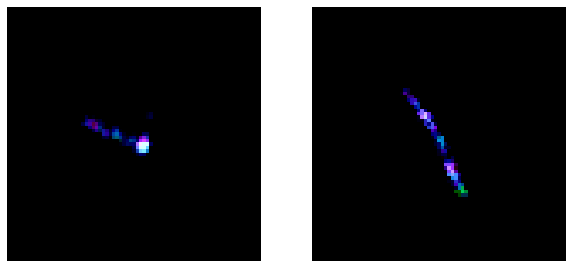

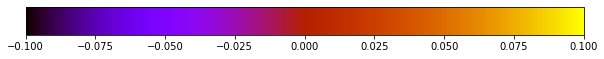

In [139]:
classes = ('iceberg','ship')

idx = 0
patch_width = 5
patch_height = 5

upsample_layer_cpu = torch.nn.Upsample(size=(75, 75), mode='bilinear', align_corners=True).cuda()
data = next(iter(test_dataset_loader))
example_l = upsample_layer_cpu(data[0][idx:idx+1]).cuda()
example_r = upsample_layer_cpu(data[1][idx:idx+1]).cuda()
label = data[2][idx:idx+1].item()
heatmap, pred = extract_patch_cam(net, img_l=example_l,img_r=example_r, patch_width=patch_width, patch_height=patch_height)
print(f"Pred: {[pred]}")
print(f"Ground truth: {[label]}")

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
for i in range(2): axes[i].axis("off")
axes[0].imshow(example_l.cpu()[0].permute(1, 2, 0))
axes[1].imshow(example_r.cpu()[0].permute(1, 2, 0))
#axes[2].imshow(upsample_layer_cpu(heatmap.unsqueeze(0))[0, 0], cmap='gnuplot')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(upsample_layer_cpu(heatmap.unsqueeze(0))[0, 0], cmap='gnuplot')
plt.gca().set_visible(False)
plt.colorbar(orientation="horizontal")